
### **1. Data Loading**

In [ ]:
!pip install nltk keras gensim scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
data= pd.read_csv('/content/drive/My Drive/data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

print("Dataset Overview:")
print(data.info())

print("Sample Data:")
print(data.head())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Description    1000 non-null   object
 1   Property Type  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB
None
Sample Data:
                                         Description Property Type
0  A retail space located in a prime commercial d...   Residential
1  A mixed-use development featuring luxury apart...    Commercial
2  A high-rise office building featuring multiple...    Industrial
3  A vast farmland with nutrient-rich soil and we...    Commercial
4  A large warehouse equipped with advanced stora...    Industrial


<ipython-input-10-89aedab22bbb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Property Type', data=data, palette='coolwarm')


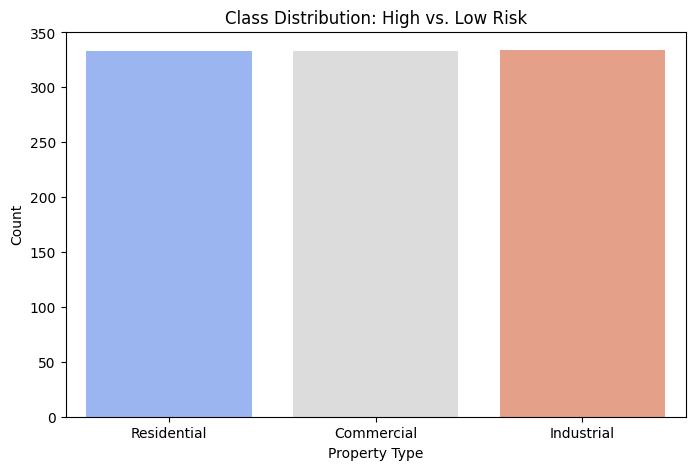


Text Length Statistics:
count    1000.000000
mean       20.922000
std         3.271792
min        17.000000
25%        18.000000
50%        21.000000
75%        23.000000
max        26.000000
Name: text_length, dtype: float64


In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Property Type', data=data, palette='coolwarm')
plt.title('Class Distribution: High vs. Low Risk')
plt.xlabel('Property Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

data['text_length'] = data['Description'].apply(lambda x: len(x.split()))
print("\nText Length Statistics:")
print(data['text_length'].describe())




In [ ]:
# Splitting Data into Train, Validation, and Test Sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Property Type'])
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42, stratify=train_data['Property Type'])

# **2. Text Procesing**

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)

    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

train_data['processed_text'] = train_data['Description'].apply(preprocess_text)
val_data['processed_text'] = val_data['Description'].apply(preprocess_text)
test_data['processed_text'] = test_data['Description'].apply(preprocess_text)

print(train_data[['Description', 'processed_text']].head())

                                           Description  \
233  A luxurious villa with an elegant private pool...   
603  A countryside farmhouse with a traditional bar...   
109  A specialized industrial plant with cutting-ed...   
318  A luxurious villa with an elegant private pool...   
32   A high-rise office building featuring multiple...   

                                        processed_text  
233  luxurious villa elegant private pool beautiful...  
603  countryside farmhouse traditional barn acre gr...  
109  specialized industrial plant cutting edge mach...  
318  luxurious villa elegant private pool beautiful...  
32   high rise office building featuring multiple f...  


# **3. Text Embedding**

In [ ]:
!pip install fasttext
import fasttext
import fasttext.util
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313506 sha256=0127db7701eea05ebe8a8b82091397fa2ed096e3d6da6aa0281dffae967f0d34
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_bow = bow_vectorizer.transform(val_data['processed_text']).toarray()
X_test_bow = bow_vectorizer.transform(test_data['processed_text']).toarray()

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_data['processed_text']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['processed_text']).toarray()

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')

def get_sentence_embeddings(text, model):
    return model.encode(text, show_progress_bar=False)

X_train_embeddings = np.array([get_sentence_embeddings(text, model) for text in train_data['processed_text']])
X_val_embeddings = np.array([get_sentence_embeddings(text, model) for text in val_data['processed_text']])
X_test_embeddings = np.array([get_sentence_embeddings(text, model) for text in test_data['processed_text']])

print("Feature extraction completed using SentenceTransformer embeddings.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Feature extraction completed using SentenceTransformer embeddings.


# **4. Model Training with Different Architectures**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Bidirectional, Flatten

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['Property Type'])
y_val = label_encoder.transform(val_data['Property Type'])
y_test = label_encoder.transform(test_data['Property Type'])

X_train = X_train_embeddings.reshape((X_train_embeddings.shape[0], 1, X_train_embeddings.shape[1]))
X_val = X_val_embeddings.reshape((X_val_embeddings.shape[0], 1, X_val_embeddings.shape[1]))
X_test = X_test_embeddings.reshape((X_test_embeddings.shape[0], 1, X_test_embeddings.shape[1]))

def cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def cnn_bilstm_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (1, 384)  # Shape for SentenceTransformer embeddings (timesteps=1, features=384)

class_weights = {0: 1.0, 1: 308/92}  # ~3.35x weight for minority class

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn = cnn_model(input_shape)
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])
cnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64, class_weight=class_weights, callbacks=[early_stopping])

lstm = lstm_model(input_shape)
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])
lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64, class_weight=class_weights, callbacks=[early_stopping])

cnn_bilstm = cnn_bilstm_model(input_shape)
cnn_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])
cnn_bilstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64, class_weight=class_weights, callbacks=[early_stopping])

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3348 - loss: 1.1156 - weighted_accuracy: 0.5883 - val_accuracy: 0.3375 - val_loss: 0.3971 - val_weighted_accuracy: 0.3375
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3326 - loss: 0.6354 - weighted_accuracy: 0.6247 - val_accuracy: 0.3375 - val_loss: 0.0957 - val_weighted_accuracy: 0.3375
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3149 - loss: 0.1963 - weighted_accuracy: 0.6058 - val_accuracy: 0.3375 - val_loss: -0.0475 - val_weighted_accuracy: 0.3375
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3236 - loss: -0.0136 - weighted_accuracy: 0.6152 - val_accuracy: 0.3375 - val_loss: -0.0863 - val_weighted_accuracy: 0.3375
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3338 - loss: 0.0038 - weighted_accuracy: 0.6262 - val_accuracy: 0.3375 - val_loss: -0.0784 - val_weighted_accuracy: 0.3375
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3456 - lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.3149 - loss: 1.1175 - weighted_accuracy: 0.5561 - val_accuracy: 0.3375 - val_loss: 0.5085 - val_weighted_accuracy: 0.3375
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3296 - loss: 0.8264 - weighted_accuracy: 0.6214 - val_accuracy: 0.3375 - val_loss: 0.3220 - val_weighted_accuracy: 0.3375
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3548 - loss: 0.5437 - weighted_accuracy: 0.6474 - val_accuracy: 0.3375 - val_loss: 0.1676 - val_weighted_accuracy: 0.3375
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3275 - loss: 0.3472 - weighted_accuracy: 0.6197 - val_accuracy: 0.3375 - val_loss: 0.0701 - val_weighted_accuracy: 0.3375
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3482 - loss: 0.2837 - weighted_accuracy: 0.6411 - val_accuracy: 0.3375 - val_loss: 0.0188 - val_weighted_accuracy: 0.3375
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3100 - loss

# **5. Comparative Analysis of Models**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_cnn = cnn.predict(X_test)
y_pred_lstm = lstm.predict(X_test)
y_pred_cnn_bilstm = cnn_bilstm.predict(X_test)

cnn_acc = accuracy_score(y_test, y_pred_cnn.round())
print("CNN Accuracy:", cnn_acc)
print("CNN Classification Report:\n", classification_report(y_test, y_pred_cnn.round()))

lstm_acc = accuracy_score(y_test, y_pred_lstm.round())
print("LSTM Accuracy:", lstm_acc)
print("LSTM Classification Report:\n", classification_report(y_test, y_pred_lstm.round()))

cnn_bilstm_acc = accuracy_score(y_test, y_pred_cnn_bilstm.round())
print("CNN-BiLSTM Accuracy:", cnn_bilstm_acc)
print("CNN-BiLSTM Classification Report:\n", classification_report(y_test, y_pred_cnn_bilstm.round()))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step
CNN Accuracy: 0.335
CNN Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        67
           1       0.34      1.00      0.50        67
           2       0.00      0.00      0.00        66

    accuracy                           0.34       200
   macro avg       0.11      0.33      0.17       200
weighted avg       0.11      0.34      0.17       200

LSTM Accuracy: 0.335
LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        67
           1       0.34      1.00      0.50        67
           2       0.00      0.00      0.00        66

    accuracy                           0.34       200
   macro avg       0.11      0.33      0.17       200
weighted avg       0.11      0.34      0.17       200

CNN-BiLSTM Accuracy: 0.335
CNN-BiLSTM Classification Report:
               precision    recall  f1-s

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

# **6. Saving the Best Model**

In [ ]:
cnn_bilstm.save('best_text_classification_model.h5')
print("Best model saved as 'best_text_classification_model.h5'")

Best model saved as 'best_text_classification_model.h5'


# **7. Prediction on Real-World Input**

In [ ]:
from keras.models import load_model
model = load_model('best_text_classification_model.h5')

new_text = "Set in a high-demand hub, this property has modern office spaces and great networking opportunities. Best suited for startups and established firms."

processed_text = preprocess_text(new_text)

model_transformer = SentenceTransformer('all-MiniLM-L6-v2')  # Same model used in training
input_embedding = model_transformer.encode(processed_text, show_progress_bar=False)

input_data = input_embedding.reshape(1, 1, 384)

predicted_prob = model.predict(input_data)
predicted_class = predicted_prob.round()[0][0]  # Get the scalar value and round it

label_map = {0: "Residential", 1: "Commercial", 2: "Industrial"}
predicted_label = label_map[int(predicted_class)]
print(f"Predicted Class: {predicted_label} (Probability: {predicted_prob[0][0]:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: Commercial (Probability: 0.99)
